In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import aic, bic


In [3]:
factor_data = pd.read_csv('./BTC_10m_active_3m_6m.csv')
factor_data['datetime'] = pd.to_datetime(factor_data['datetime'])
factor_data = factor_data.set_index('datetime')
# factor_data.query('datetime >= "2023-01-01"', inplace=True)

# factor_data['active_3m_6m'] = np.log(factor_data['active_3m_6m'] + 1)

factor_data_10m = factor_data
factor_data_1h = factor_data.resample('1h').mean()
factor_data_1d = factor_data.resample('1D').mean()

factor_data_1d.query('datetime >= "2023-01-01"', inplace=True)

In [4]:
factor_data_1d

,active_3m_6m
datetime,
2023-01-01,8.947136e+05
2023-01-02,8.929458e+05
2023-01-03,8.926328e+05
2023-01-04,8.951429e+05
2023-01-05,8.971683e+05
...,...
2025-06-03,2.198688e+06
2025-06-04,2.067080e+06
2025-06-05,1.932565e+06


In [5]:
factor_data_1d_demo = factor_data_1d.copy()
factor_data_1d_demo['lag_1'] = factor_data_1d_demo['active_3m_6m'].shift(1)
factor_data_1d_demo.dropna(inplace=True)
px.line(factor_data_1d_demo, x=factor_data_1d_demo.index, y=['active_3m_6m', 'lag_1'], title='Active 3m-6m and Lag 1 Day').show()

In [6]:
px.line(factor_data_1d)

In [7]:
# def adf_test(series):
#     result = adfuller(series)
#     print(f'ADF Statistic: {result[0]}')
#     print(f'p-value: {result[1]}')
#     if result[1] < 0.05:
#         print("数据平稳")
#     else:
#         print("数据非平稳")

# # 进行平稳性检验, 原始因子时间序列不平稳， 经过差分之后平稳
# adf_test(factor_data_1d.dropna())

adfuller(factor_data_1d['active_3m_6m'].dropna())


(-3.6084962959966926,
 0.005600658893362316,
 14,
 874,
 {'1%': -3.437854130362047,
  '5%': -2.8648525821630173,
  '10%': -2.5685338603647714},
 20214.493853956155)

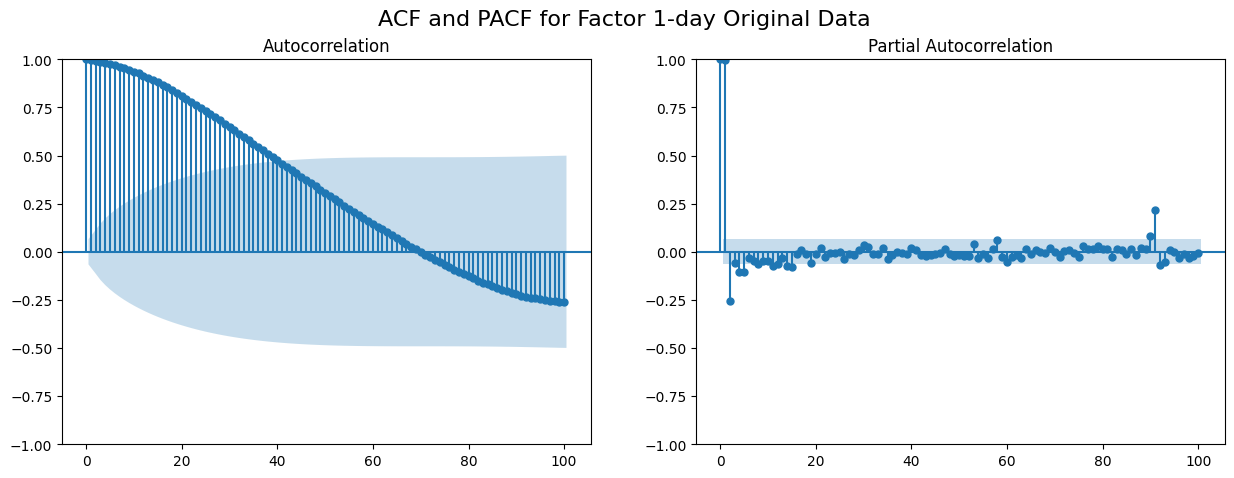

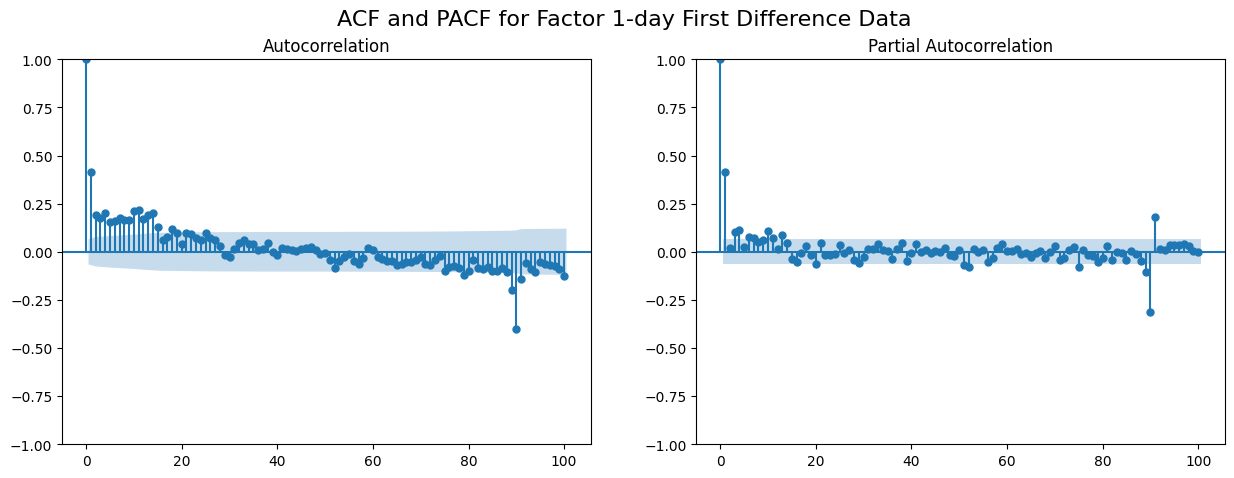

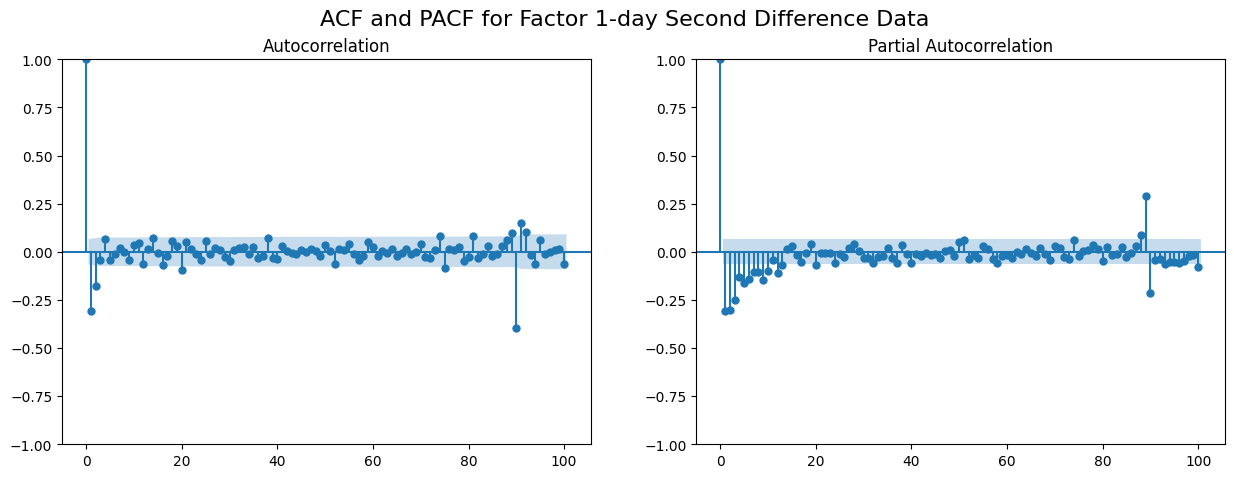

In [8]:
def plot_acf_pacf(series, freq_label="Frequency"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(series, lags=100, ax=axes[0])
    plot_pacf(series, lags=100, ax=axes[1])
    fig.suptitle(f"ACF and PACF for Factor {freq_label} Data", fontsize=16)
    plt.show()


# Plot ACF and PACF for 1-day frequency differenced data
plot_acf_pacf(factor_data_1d.dropna(), "1-day Original")

plot_acf_pacf(factor_data_1d.diff().dropna(), "1-day First Difference")

plot_acf_pacf(factor_data_1d.diff().diff().dropna(), "1-day Second Difference")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



AIC: 17234.312847201407
BIC: 17262.405498786105


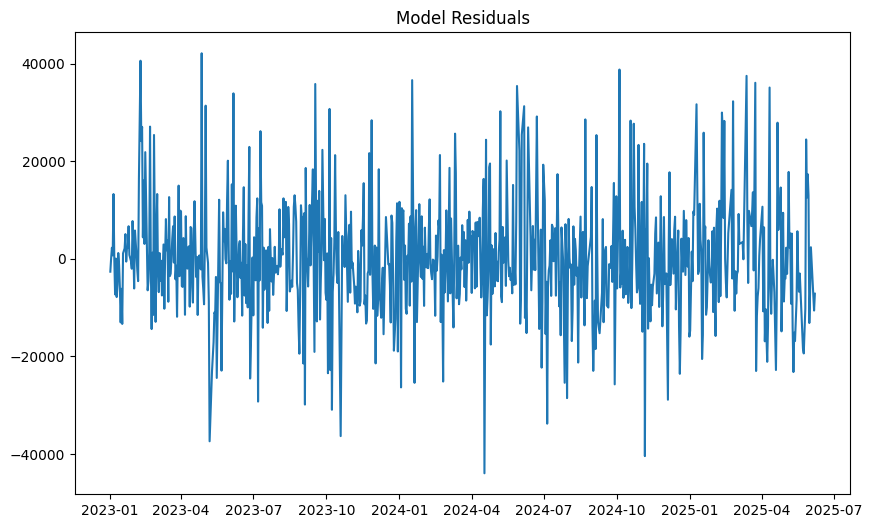

In [9]:
# 拟合 ARMA 模型
factor = factor_data_1d.diff().dropna()
# 去除top和bottom 1% 的异常值
lower_bound = factor['active_3m_6m'].quantile(0.05)
upper_bound = factor['active_3m_6m'].quantile(0.95)
factor = factor[(factor['active_3m_6m'] >= lower_bound) & (factor['active_3m_6m'] <= upper_bound)]



p, q = 2, 2
model = ARIMA(factor, order=(p, 0, q))  # ARMA 没有差分部分，所以差分阶数 d=0
model_fit = model.fit()

# 5. 模型诊断：查看 AIC 和 BIC
print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')

# 6. 残差分析
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Model Residuals")
plt.show()

In [10]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.simplefilter("ignore")

# 假设 factor_data_1h 是你的原始数据，'active_3m_6m' 是你要分析的因子列
factor = factor_data_1h
div_num = 12


# 去除异常值（上下5%的数据）
lower_bound = factor.quantile(0.05)
upper_bound = factor.quantile(0.95)
factor = factor[(factor >= lower_bound) & (factor <= upper_bound)]
factor.asfreq = 'H'


n = len(factor)
split_size = n // div_num  # 计算每份数据的大小
chunks = [factor[i:i + split_size] for i in range(0, n, split_size)]

# 如果不能整除，最后一段数据可能会少一些，补充完整
if len(chunks) < div_num:
    chunks[-2] = pd.concat([chunks[-2], chunks[-1]])  # 将最后一段合并到倒数第二段
    chunks = chunks[:-1]  # 移除最后一段（数据会平滑分布）

# 定义 p 和 q 的范围
p_values = range(0, 5)  # ARIMA的p的值
q_values = range(0, 5)  # ARIMA的q的值
d_values = [0, 1, 2]

# 用于存储每个月的 AIC 和 BIC
results = []

# 对每个分段的数据进行建模
for i, data in enumerate(chunks):
    for p in p_values:
        for q in q_values:
            for d in d_values:
                try:
                    # 训练 ARIMA 模型
                    model = ARIMA(data, order=(p, d, q))  # 这里 d=0 表示没有差分部分
                    model_fit = model.fit()

                    # 获取 AIC 和 BIC 值
                    aic = model_fit.aic
                    bic = model_fit.bic

                    # 将结果添加到 monthly_results 中
                    results.append({'Segment': i+1, 'p': p, 'q': q, 'AIC': aic, 'BIC': bic})
                    print(f"Segment {i+1} | ARIMA({p}, 0, {q}) - AIC: {aic}, BIC: {bic}")

                except Exception as e:
                    print(f"Error fitting model ARIMA({p}, 0, {q}) for Segment {i+1}: {e}")
                    continue

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)


Segment 1 | ARIMA(0, 0, 0) - AIC: 117965.54519446596, BIC: 117977.71061673443
Segment 1 | ARIMA(0, 0, 0) - AIC: 62576.544622894595, BIC: 62582.62702514852
Segment 1 | ARIMA(0, 0, 0) - AIC: 63335.27449752303, BIC: 63341.35659080121
Segment 1 | ARIMA(0, 0, 1) - AIC: 92614.16672000977, BIC: 92632.41485341248
Segment 1 | ARIMA(0, 0, 1) - AIC: 62591.139025068136, BIC: 62603.30382957599
Segment 1 | ARIMA(0, 0, 1) - AIC: 63369.25447188184, BIC: 63381.4186584382
Segment 1 | ARIMA(0, 0, 2) - AIC: 92024.67866885301, BIC: 92049.00951338996
Segment 1 | ARIMA(0, 0, 2) - AIC: 62593.17118900073, BIC: 62611.41839576251
Segment 1 | ARIMA(0, 0, 2) - AIC: 63410.412948618396, BIC: 63428.65922845293
Segment 1 | ARIMA(0, 0, 3) - AIC: 91880.7154018569, BIC: 91911.12895752808
Segment 1 | ARIMA(0, 0, 3) - AIC: 62597.25736705786, BIC: 62621.58697607356
Segment 1 | ARIMA(0, 0, 3) - AIC: 63392.75334995492, BIC: 63417.08172306763
Segment 1 | ARIMA(0, 0, 4) - AIC: 91841.40858598467, BIC: 91877.90485279009
Segment 1

KeyboardInterrupt: 

In [ ]:
results_df['param'] = results_df.apply(lambda row: f"ARIMA({int(row['p'])},0,{int(row['q'])})", axis=1)
results_df['metric'] = results_df['AIC'] + results_df['BIC']

In [ ]:

fig1 = px.line(results_df, x='Segment', y='AIC', color='param', title='AIC Values for Different ARIMA Models Across Segments')
fig2 = px.line(results_df, x='Segment', y='BIC', color='param', title='BIC Values for Different ARIMA Models Across Segments')
fig3 = px.line(results_df, x='Segment', y='metric', color='param', title='AIC + BIC Values for Different ARIMA Models Across Segments')
fig1.show()
fig2.show()
fig3.show()

In [ ]:
results_df

,Segment,p,q,AIC,BIC,param,metric
0,1,0,0,28649.397168,28660.363657,"ARIMA(0,0,0)",57309.760825
1,1,0,1,23051.407720,23067.857453,"ARIMA(0,0,1)",46119.265173
2,1,0,2,22881.420423,22903.353401,"ARIMA(0,0,2)",45784.773824
3,1,0,3,22824.918452,22852.334674,"ARIMA(0,0,3)",45677.253126
4,1,0,4,22796.667059,22829.566525,"ARIMA(0,0,4)",45626.233584
...,...,...,...,...,...,...,...
294,12,4,0,17339.328664,17372.228131,"ARIMA(4,0,0)",34711.556795
295,12,4,1,17359.236018,17397.618729,"ARIMA(4,0,1)",34756.854747
296,12,4,2,17333.768050,17377.634005,"ARIMA(4,0,2)",34711.402055
297,12,4,3,17338.810706,17388.159905,"ARIMA(4,0,3)",34726.970611


In [ ]:
results_df

avg_results_df = results_df.groupby(['param']).mean().sort_values(by=['metric']).drop(columns=['p', 'q', 'Segment']).reset_index()
avg_results_df

,param,AIC,BIC,metric
0,"ARIMA(4,0,0)",30580.835070,30613.734536,61194.569606
1,"ARIMA(3,0,1)",30890.572856,30923.472322,61814.045178
2,"ARIMA(3,0,0)",30893.393785,30920.810008,61814.203793
3,"ARIMA(1,0,4)",30888.913185,30927.295896,61816.209080
4,"ARIMA(3,0,2)",30889.604868,30927.987579,61817.592447
5,"ARIMA(4,0,1)",30890.463652,30928.846363,61819.310015
6,"ARIMA(1,0,3)",30893.461223,30926.360689,61819.821912
7,"ARIMA(2,0,2)",30893.786690,30926.686156,61820.472846
8,"ARIMA(1,0,2)",30897.718016,30925.134238,61822.852255
9,"ARIMA(2,0,4)",30890.946845,30934.812800,61825.759646


In [ ]:
results_df.sort_values(by=['metric']).head(10)

,Segment,p,q,AIC,BIC,param,metric
11,1,2,1,17123.810655,17151.226877,"ARIMA(2,0,1)",34275.037532
10,1,2,0,17133.987704,17155.920682,"ARIMA(2,0,0)",34289.908386
6,1,1,1,17134.381326,17156.314304,"ARIMA(1,0,1)",34290.695630
17,1,3,2,17126.191093,17164.573804,"ARIMA(3,0,2)",34290.764897
15,1,3,0,17135.822590,17163.238812,"ARIMA(3,0,0)",34299.061402
7,1,1,2,17135.965853,17163.382075,"ARIMA(1,0,2)",34299.347927
5,1,1,0,17144.926094,17161.375828,"ARIMA(1,0,0)",34306.301922
20,1,4,0,17137.158310,17170.057776,"ARIMA(4,0,0)",34307.216086
8,1,1,3,17137.573397,17170.472864,"ARIMA(1,0,3)",34308.046261
16,1,3,1,17137.959133,17170.858600,"ARIMA(3,0,1)",34308.817733


In [ ]:
train_data = factor_data_1d[: int(len(factor_data_1d)*0.8)]
train_data

selected_model = ARIMA(train_data, order=(4, 0, 1))  # 这里 d=0 表示没有差分部分
model_fit = selected_model.fit()

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           active_3m_6m   No. Observations:                  711
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -8226.464
Date:                Tue, 04 Nov 2025   AIC                          16466.928
Time:                        16:48:17   BIC                          16498.895
Sample:                    01-01-2023   HQIC                         16479.276
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.457e+06   7.56e-09   1.93e+14      0.000    1.46e+06    1.46e+06
ar.L1          2.1706      0.035     62.767      0.000       2.103       2.238
ar.L2         -1.4934      0.075    -19.959      0.0

In [ ]:
px.line(model_fit.resid)

In [ ]:
from pykalman import KalmanFilter

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(model_fit.resid, n_iter=10)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(model_fit.resid)
px.line(smoothed_state_means)

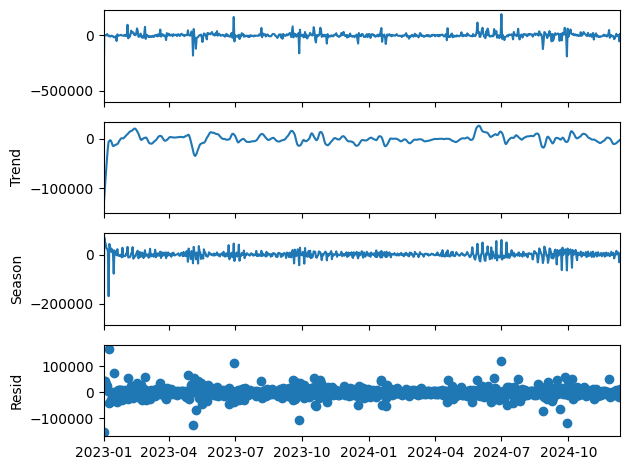

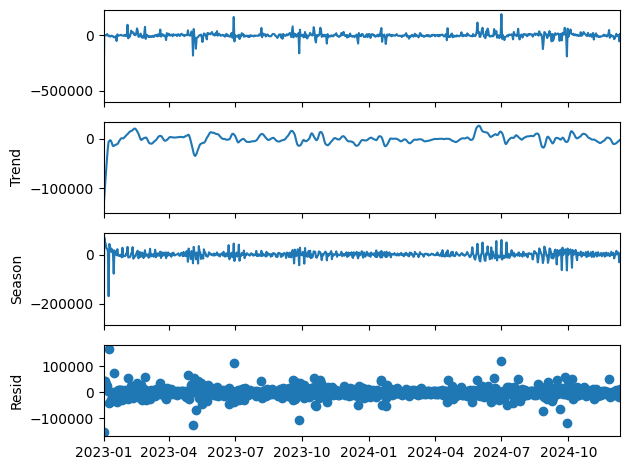

In [ ]:
from statsmodels.tsa.seasonal import STL
model_resid = model_fit.resid.dropna()

# 使用STL分解残差序列
stl = STL(model_resid)
result = stl.fit()
result.plot()


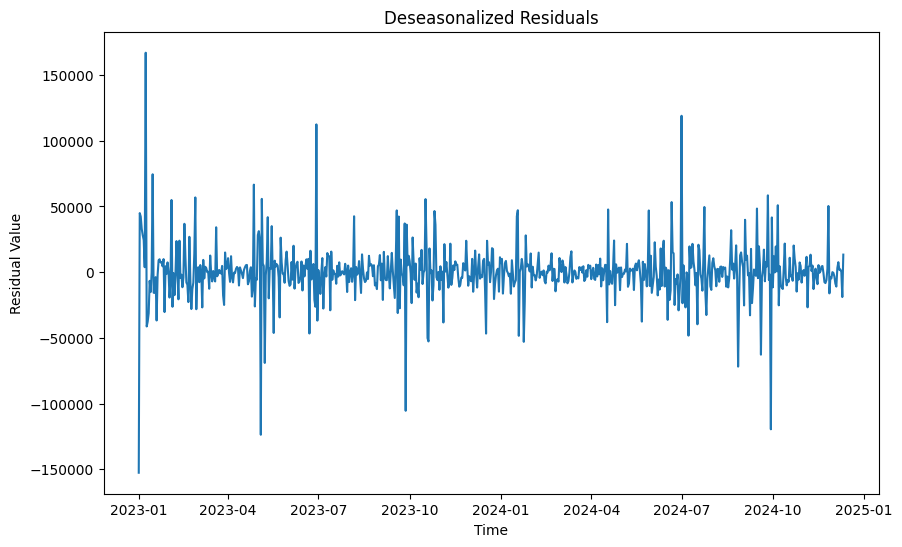

In [ ]:
deseasonalized_residuals = result.resid

# 绘制去季节性后的残差
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_residuals)
plt.title("Deseasonalized Residuals")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.show()

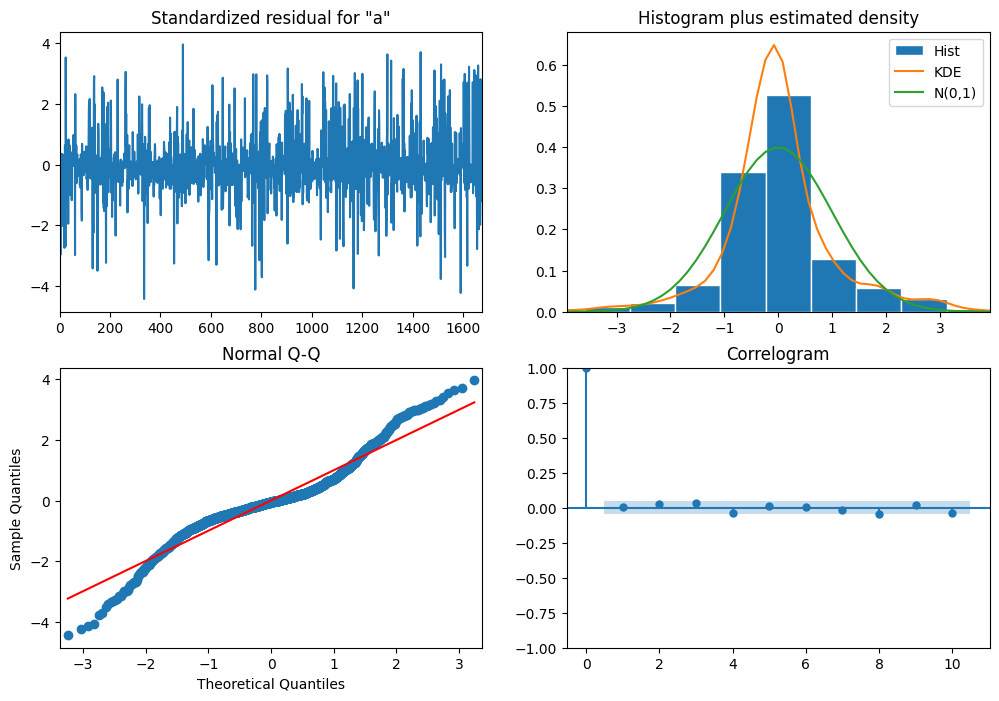

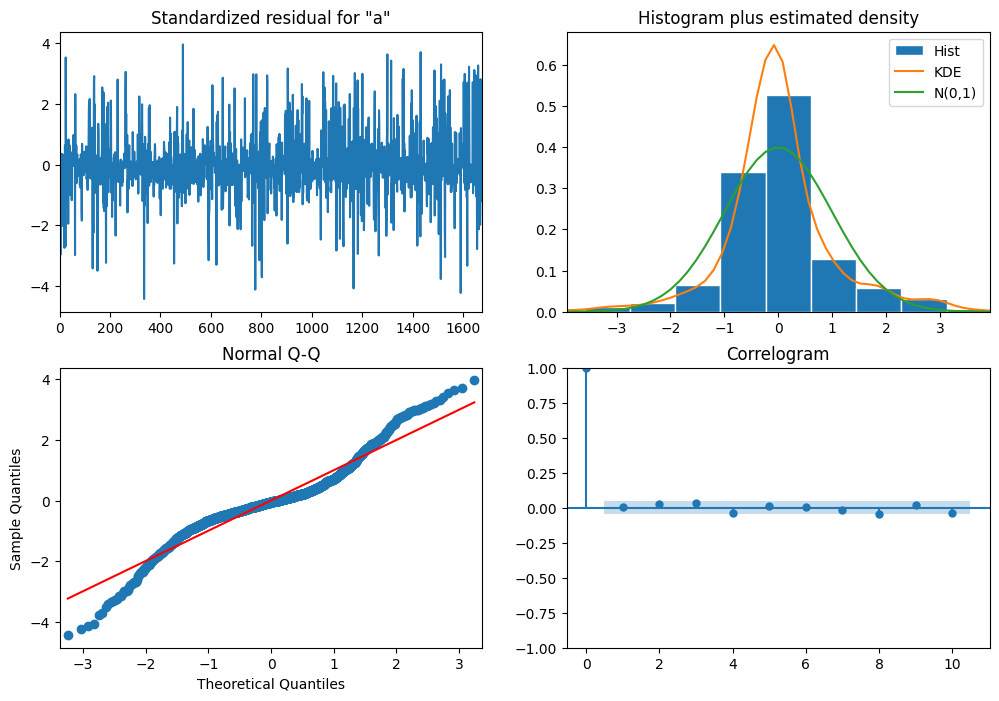

In [ ]:
model_fit.plot_diagnostics(figsize=(12, 8))